<a href="https://colab.research.google.com/github/kimheeseo/python/blob/main/cha4_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**chatper 4. 이미지 처리와 합성곱 신경망**

In [1]:
# 이미지 분야에서 합성곱(convolution)이란, 이미지 위에 작은 커널 행렬을 이동시켜 가면서
# 각 요소의 곱을 계산해 가는 방식.

# 커널의 계수를 변경하면 이미지를 날카롭게 만든다든가 경계선을 추출하는 등 다양한 처리가 가능하다.

**CNN을 사용한 이미지 분류**

In [2]:
# CNN을 사용한 이미지 분류는 기본적으로 합성곱으로부터 ReLU 등의
# 활성화 함수를 적용하는 과정을 여러 번 실시하면 된다.

# 이미지 데이터: (C,H,W) 형식
# H, W: 이미지의 세로, 가로 크기, C: 색수 또는 채널

# 이 처리를 통해 얻은 특이량을 MLP에 넣어서 최종적인 분류를 판별하게 된다.
# 합성곱 처리 후에는 위치 감도를 높이는 pooling을 적용하거나, dropout, batch normalization을
# 함께 사용하는 경우도 많다.

**Fashion-MNIST**

In [3]:
# MNIST: 28 x 28 픽셀의 흑백 손글씨 숫자 데이터.
# 이 MNIST가 너무 간단하다는 지적도 있어서 손글씨 문자 대신에 10가지 분류의 옷 및 액세서리를
# 이미지 데이터로 이루어진 Fashion-MNIST가 고안됐다.

# Fahion-MNIST: 28 x 28 픽셀 크기의 흑백 이미지.

In [4]:
# 파이토치의 확장 기능인 torchvision이라는 라이브러리를 사용하면, Fashion-MNIST 데이터 다운로드부터,
# Dataset으로 변환, DataLoader 작성까지 할 수 있다.

In [5]:
import torch
from torch import nn, optim
from torch.utils.data import (Dataset, DataLoader, TensorDataset)
import tqdm

from torchvision.datasets import FashionMNIST
from torchvision import transforms

In [6]:
# 훈련용 데이터 가져오기
# 초기 상태에선 PIL(Python Imaging Library) 이미지 형식으로 Dataset를 만들어 버린다.
# transfroms.ToTensor를 사용해 텐서로 변환한다.
fashion_mnist_train=FashionMNIST("/content/drive/MyDrive/Colab Notebooks/파이토치첫걸음/FashionMNIST",train=True, download=True, transform=transforms.ToTensor())

In [7]:
# 검증용 데이터 가져오기
fashion_mnist_test=FashionMNIST("/content/drive/MyDrive/Colab Notebooks/파이토치첫걸음/FashionMNIST",train=False, download=True, transform=transforms.ToTensor())

In [8]:
# 배치 크기 128인 DataLoader를 각각 작성
batch_size=128
train_loader=DataLoader(fashion_mnist_train, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=False)

**CNN 구축과 학습**

In [9]:
# 파이토치 이미지의 합성곱 처리를 위한 nn.Conv2d나 풀링을 위한 nn.MaxPool2d 등을 제공하므로 바로 CNN을 구축할 수 있다.
# 2계층 합성곱과 2계층 MLP를 연결한 CNN 작성

# 2층 합성곱과 2층 MLP를 연결한 CNN작성
# 합성곱 출력을 MLP에 전달할 때 필요

class FlattenLayer(nn.Module):
  def forward(self, x):
    sizes=x.size()
    return x.view(sizes[0], -1)

# 5x5의 커널을 사용해서 처음에 32개, 다음에 64개의 채널 작성
# BatchNorm2d: 이미지용 Batch Normalization
# Dropout2d: 이미지용 Dropout
# 마지막으로 FlattenLayer 적용

conv_net=nn.Sequential(
    nn.Conv2d(1,32,5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.25),

    nn.Conv2d(32,64,5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.25),
    FlattenLayer()
)

# 합성곱에 의해 최종적으로 이미지 크기가 어떤지를 더미 데이터에 넣어서 확인한다.
test_input=torch.ones(1,1,28,28)
conv_output_size=conv_net(test_input).size()[-1]

# 2층 MLP
mlp=nn.Sequential(
    nn.Linear(conv_output_size,200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200,10)
)

# 최종 CNN
net=nn.Sequential(
    conv_net,
    mlp
)

In [10]:
test_input=torch.ones(1,1,28,28)
conv_output_size=conv_net(test_input).size()[-1]

print('test_input.size():',test_input.size())
print('conv_output_size값:',conv_output_size)

test_input.size(): torch.Size([1, 1, 28, 28])
conv_output_size값: 1024


In [11]:
conv_net(test_input).size()

torch.Size([1, 1024])

**평가와 훈련용 헬퍼 함수 작성**

In [12]:
# 평가용 헬퍼 함수
def eval_net(net, data_loader):
  # dropout 및 batchnorm을 무효화
  net.eval()
  ys=[]
  ypreds=[]

  for x, y in data_loader:
    with torch.no_grad():
      _, y_pred=net(x).max(1)
    ys.append(y)
    ypreds.append(y_pred)

  # 미니 배치 단위의 예측 결과 등을 하나로 묶는다.
  ys=torch.cat(ys)
  ypreds=torch.cat(ypreds)

  # 예측 정확도 계산
  acc=(ys==ypreds).float().sum()/len(ys)
  return acc.item()

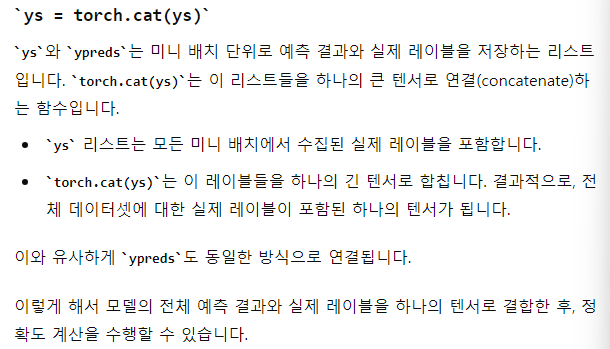

In [37]:
# 훈련용 헬퍼 함수
def train_net(net, train_loader, test_loader, optimizer_cls=optim.Adam, loss_fn=nn.CrossEntropyLoss(), n_iter=20):
  train_losses=[]
  train_acc=[]
  val_acc=[]
  optimizer=optimizer_cls(net.parameters())

  for epoch in range(n_iter):
    running_loss=0.0

    net.train() # 신경망을 훈련 모드로 설정
    n=0
    n_acc=0

    for i, (xx,yy) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
      h=net(xx)
      loss=loss_fn(h,yy)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()
      n+=len(xx)
      _,y_pred=h.max(1)
      n_acc+=(yy==y_pred).float().sum().item()

    train_losses.append(running_loss/i)
    train_acc.append(n_acc/n)

    # 검증 데이터의 예측 정확도
    val_acc.append(eval_net(net, test_loader))

    # epoch의 결과 표시
    print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)
  return train_acc, val_acc, train_losses

In [38]:
# 훈련 실행
(train_acc, val_acc,train_losses)=train_net(net, train_loader, test_loader, n_iter=20)

100%|██████████| 469/469 [01:10<00:00,  6.61it/s]


0 0.2461852280693686 0.9106833333333333 0.9092000126838684


100%|██████████| 469/469 [01:03<00:00,  7.38it/s]


1 0.23517826887277457 0.9140833333333334 0.9103000164031982


100%|██████████| 469/469 [01:02<00:00,  7.44it/s]


2 0.2193103650600737 0.9193 0.9178000092506409


100%|██████████| 469/469 [01:02<00:00,  7.53it/s]


3 0.209343901843342 0.92205 0.9126999974250793


100%|██████████| 469/469 [01:02<00:00,  7.55it/s]


4 0.20381760098931626 0.9242333333333334 0.9193000197410583


100%|██████████| 469/469 [01:02<00:00,  7.56it/s]


5 0.1951379061350201 0.92765 0.9157000184059143


100%|██████████| 469/469 [01:02<00:00,  7.55it/s]


6 0.18961052743033466 0.9299833333333334 0.9139000177383423


100%|██████████| 469/469 [01:02<00:00,  7.49it/s]


7 0.18329144641757011 0.9322333333333334 0.919700026512146


100%|██████████| 469/469 [01:02<00:00,  7.48it/s]


8 0.17886113638902068 0.9329 0.9154000282287598


100%|██████████| 469/469 [01:02<00:00,  7.47it/s]


9 0.17374510262320694 0.9350666666666667 0.919700026512146


100%|██████████| 469/469 [01:02<00:00,  7.53it/s]


10 0.1676331270390596 0.9376333333333333 0.919700026512146


100%|██████████| 469/469 [01:02<00:00,  7.48it/s]


11 0.16489884652929682 0.93845 0.9218000173568726


100%|██████████| 469/469 [01:02<00:00,  7.45it/s]


12 0.15936957090360743 0.9404166666666667 0.9221000075340271


100%|██████████| 469/469 [01:03<00:00,  7.40it/s]


13 0.15827326376277667 0.9407666666666666 0.92330002784729


100%|██████████| 469/469 [01:03<00:00,  7.41it/s]


14 0.15202391996947873 0.9432666666666667 0.9243999719619751


100%|██████████| 469/469 [01:03<00:00,  7.43it/s]


15 0.15167097510913244 0.9430166666666666 0.92330002784729


100%|██████████| 469/469 [01:03<00:00,  7.44it/s]


16 0.15035599587946877 0.94395 0.9215999841690063


100%|██████████| 469/469 [01:03<00:00,  7.43it/s]


17 0.14528485524476084 0.9459333333333333 0.9243000149726868


100%|██████████| 469/469 [01:02<00:00,  7.45it/s]


18 0.14324469834916356 0.9461666666666667 0.9223999977111816


100%|██████████| 469/469 [01:02<00:00,  7.46it/s]


19 0.14169660445430085 0.9468833333333333 0.925000011920929


In [39]:
val_acc

[0.9092000126838684,
 0.9103000164031982,
 0.9178000092506409,
 0.9126999974250793,
 0.9193000197410583,
 0.9157000184059143,
 0.9139000177383423,
 0.919700026512146,
 0.9154000282287598,
 0.919700026512146,
 0.919700026512146,
 0.9218000173568726,
 0.9221000075340271,
 0.92330002784729,
 0.9243999719619751,
 0.92330002784729,
 0.9215999841690063,
 0.9243000149726868,
 0.9223999977111816,
 0.925000011920929]

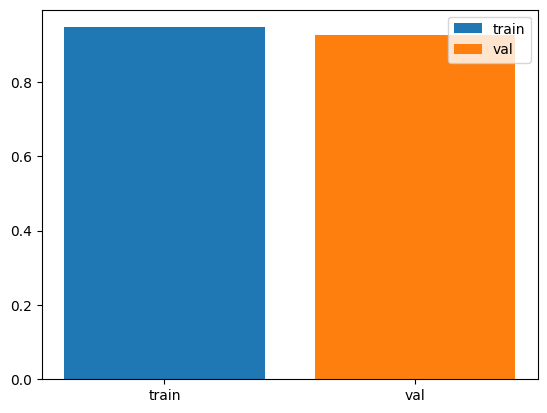

In [40]:
from matplotlib import pyplot as plt
plt.bar('train', train_acc,label='train')
plt.bar('val', val_acc,label='val')
plt.legend()
plt.show()

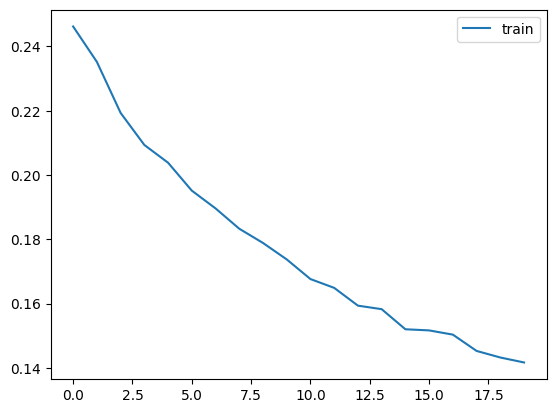

In [45]:
from matplotlib import pyplot as plt
plt.plot(train_losses,label='train')
plt.legend()
plt.show()

In [ ]:
# CNN: 다양한 구조가 존재하며, VGG, Inception, ResNet 등은 정확도가 높기로 유명하다.
# 이 모델들은 층이 매우 깊은 신경망 구조로, 대량의 파라미터를 가지고 있으며, 과학습 없이 파라미터를
# 최적화하려면 훈련용 이미지도 대량으로 필요하다. 이미지를 수집해야 하는 것뿐만 아니라, 각각에 레이블을 붙이는
# 작업도 매우 힘든 작업이다.

In [42]:
# CIFAR-10, ImageNet 등 레이블이 할당된 범용 데이터를 사용할 때는 문제가 없지만, 실제로 자신의 서비스에서 사용할
# 이미지로 모델을 훈련하려고 하면 이런 작업은 많은 수고가 따른다. 또한, 이미지 데이터 자체를 수집하기 어려운 경우도 있다.
# 다행히 이 문제는 전이 학습이라는 기법을 이용하면 해결할 수 있다.

In [43]:
train_losses

[0.2461852280693686,
 0.23517826887277457,
 0.2193103650600737,
 0.209343901843342,
 0.20381760098931626,
 0.1951379061350201,
 0.18961052743033466,
 0.18329144641757011,
 0.17886113638902068,
 0.17374510262320694,
 0.1676331270390596,
 0.16489884652929682,
 0.15936957090360743,
 0.15827326376277667,
 0.15202391996947873,
 0.15167097510913244,
 0.15035599587946877,
 0.14528485524476084,
 0.14324469834916356,
 0.14169660445430085]